<a href="https://colab.research.google.com/github/heodawoon/dino/blob/main/Review_DINO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [AAA738] Code Review
- Emerging Properties in Self-Supervised Vision Transformers (Caron et al., *arXiv*, 2021)
- Student name (ID): Junyeong Maeng (2021010535), Da-Woon Heo (2020010175)
- Date: 2021.10.14.

In [ ]:
import argparse
import os
import sys
import datetime
import time
import math
import json
from pathlib import Path

import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.distributed as dist
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision import models as torchvision_models

import utils
import vision_transformer as vits
from vision_transformer import DINOHead

In [ ]:
torchvision_archs = sorted(name for name in torchvision_models.__dict__
    if name.islower() and not name.startswith("__")
    and callable(torchvision_models.__dict__[name]))

In [ ]:
def get_args_parser():
    parser = argparse.ArgumentParser('DINO', add_help=False)

    # Model parameters
    parser.add_argument('--arch', default='vit_tiny', type=str,
        choices=['vit_tiny', 'vit_small', 'vit_base', 'xcit', 'deit_tiny', 'deit_small'] \
                + torchvision_archs + torch.hub.list("facebookresearch/xcit:main"),
        help="""Name of architecture to train. For quick experiments with ViTs,
        we recommend using vit_tiny or vit_small.""")
    parser.add_argument('--patch_size', default=16, type=int, help="""Size in pixels
        of input square patches - default 16 (for 16x16 patches). Using smaller
        values leads to better performance but requires more memory. Applies only
        for ViTs (vit_tiny, vit_small and vit_base). If <16, we recommend disabling
        mixed precision training (--use_fp16 false) to avoid unstabilities.""")
    parser.add_argument('--out_dim', default=65536, type=int, help="""Dimensionality of
        the DINO head output. For complex and large datasets large values (like 65k) work well.""")
    parser.add_argument('--norm_last_layer', default=True, type=utils.bool_flag,
        help="""Whether or not to weight normalize the last layer of the DINO head.
        Not normalizing leads to better performance but can make the training unstable.
        In our experiments, we typically set this paramater to False with vit_small and True with vit_base.""")
    parser.add_argument('--momentum_teacher', default=0.996, type=float, help="""Base EMA
        parameter for teacher update. The value is increased to 1 during training with cosine schedule.
        We recommend setting a higher value with small batches: for example use 0.9995 with batch size of 256.""")
    parser.add_argument('--use_bn_in_head', default=False, type=utils.bool_flag,
        help="Whether to use batch normalizations in projection head (Default: False)")

    # Temperature teacher parameters
    parser.add_argument('--warmup_teacher_temp', default=0.04, type=float,
        help="""Initial value for the teacher temperature: 0.04 works well in most cases.
        Try decreasing it if the training loss does not decrease.""")
    parser.add_argument('--teacher_temp', default=0.04, type=float, help="""Final value (after linear warmup)
        of the teacher temperature. For most experiments, anything above 0.07 is unstable. We recommend
        starting with the default value of 0.04 and increase this slightly if needed.""")
    parser.add_argument('--warmup_teacher_temp_epochs', default=0, type=int,
        help='Number of warmup epochs for the teacher temperature (Default: 30).')

    # Training/Optimization parameters
    parser.add_argument('--use_fp16', type=utils.bool_flag, default=True, help="""Whether or not
        to use half precision for training. Improves training time and memory requirements,
        but can provoke instability and slight decay of performance. We recommend disabling
        mixed precision if the loss is unstable, if reducing the patch size or if training with bigger ViTs.""")
    parser.add_argument('--weight_decay', type=float, default=0.04, help="""Initial value of the
        weight decay. With ViT, a smaller value at the beginning of training works well.""")
    parser.add_argument('--weight_decay_end', type=float, default=0.4, help="""Final value of the
        weight decay. We use a cosine schedule for WD and using a larger decay by
        the end of training improves performance for ViTs.""")
    parser.add_argument('--clip_grad', type=float, default=3.0, help="""Maximal parameter
        gradient norm if using gradient clipping. Clipping with norm .3 ~ 1.0 can
        help optimization for larger ViT architectures. 0 for disabling.""")
    parser.add_argument('--batch_size_per_gpu', default=64, type=int,
        help='Per-GPU batch-size : number of distinct images loaded on one GPU.')
    parser.add_argument('--epochs', default=100, type=int, help='Number of epochs of training.')
    parser.add_argument('--freeze_last_layer', default=1, type=int, help="""Number of epochs
        during which we keep the output layer fixed. Typically doing so during
        the first epoch helps training. Try increasing this value if the loss does not decrease.""")
    parser.add_argument("--lr", default=0.0005, type=float, help="""Learning rate at the end of
        linear warmup (highest LR used during training). The learning rate is linearly scaled
        with the batch size, and specified here for a reference batch size of 256.""")
    parser.add_argument("--warmup_epochs", default=10, type=int,
        help="Number of epochs for the linear learning-rate warm up.")
    parser.add_argument('--min_lr', type=float, default=1e-6, help="""Target LR at the
        end of optimization. We use a cosine LR schedule with linear warmup.""")
    parser.add_argument('--optimizer', default='adamw', type=str,
        choices=['adamw', 'sgd', 'lars'], help="""Type of optimizer. We recommend using adamw with ViTs.""")
    parser.add_argument('--drop_path_rate', type=float, default=0.1, help="stochastic depth rate")

    # Multi-crop parameters
    parser.add_argument('--global_crops_scale', type=float, nargs='+', default=(0.4, 1.),
        help="""Scale range of the cropped image before resizing, relatively to the origin image.
        Used for large global view cropping. When disabling multi-crop (--local_crops_number 0), we
        recommand using a wider range of scale ("--global_crops_scale 0.14 1." for example)""")
    parser.add_argument('--local_crops_number', type=int, default=8, help="""Number of small
        local views to generate. Set this parameter to 0 to disable multi-crop training.
        When disabling multi-crop we recommend to use "--global_crops_scale 0.14 1." """)
    parser.add_argument('--local_crops_scale', type=float, nargs='+', default=(0.05, 0.4),
        help="""Scale range of the cropped image before resizing, relatively to the origin image.
        Used for small local view cropping of multi-crop.""")

    # Misc
    parser.add_argument('--data_path', default='./drive/data/cifar10/train/', type=str,
        help='Please specify path to the ImageNet training data.')
    parser.add_argument('--output_dir', default=".", type=str, help='Path to save logs and checkpoints.')
    parser.add_argument('--saveckp_freq', default=20, type=int, help='Save checkpoint every x epochs.')
    parser.add_argument('--seed', default=0, type=int, help='Random seed.')
    parser.add_argument('--num_workers', default=10, type=int, help='Number of data loading workers per GPU.')
    parser.add_argument("--dist_url", default="env://", type=str, help="""url used to set up
        distributed training; see https://pytorch.org/docs/stable/distributed.html""")
    parser.add_argument("--local_rank", default=0, type=int, help="Please ignore and do not set this argument.")
    parser.add_argument('-f')
    return parser

### Training (function: train_dino)
1. Prepare data augumentation
2. Building student and teacher networks
3. Prepare loss, optimization, etc.
4. Process training

In [ ]:
'''
1. Prepare data augumentation
2. Building student and teacher networks
'''

def train_dino(args):
    utils.init_distributed_mode(args)
    utils.fix_random_seeds(args.seed)
    print("git:\n  {}\n".format(utils.get_sha()))
    print("\n".join("%s: %s" % (k, str(v)) for k, v in sorted(dict(vars(args)).items())))
    cudnn.benchmark = True

    # ============ preparing data ... ============
    transform = DataAugmentationDINO(
        args.global_crops_scale, # (0.4, 1.0)
        args.local_crops_scale, # (0.05, 0.4)
        args.local_crops_number, # 8
    )
    dataset = datasets.ImageFolder(args.data_path, transform=transform)
    sampler = torch.utils.data.DistributedSampler(dataset, shuffle=True)
    data_loader = torch.utils.data.DataLoader(
        dataset,
        sampler=sampler,
        batch_size=args.batch_size_per_gpu,
        num_workers=args.num_workers,
        pin_memory=True,
        drop_last=True,
    )
    print(f"Data loaded: there are {len(dataset)} images.")

    # ============ building student and teacher networks ... ============
    # we changed the name DeiT-S for ViT-S to avoid confusions
    args.arch = args.arch.replace("deit", "vit")
    # if the network is a Vision Transformer (i.e. vit_tiny, vit_small, vit_base)
    if args.arch in vits.__dict__.keys():
        student = vits.__dict__[args.arch](
            patch_size=args.patch_size, # 16
            drop_path_rate=args.drop_path_rate,  # stochastic depth # 0.1
        ) # check 'vit_tiny'
        teacher = vits.__dict__[args.arch](patch_size=args.patch_size)
        embed_dim = student.embed_dim # vit_tiny: 192
    '''
    # if the network is a XCiT
    elif args.arch in torch.hub.list("facebookresearch/xcit:main"):
        student = torch.hub.load('facebookresearch/xcit:main', args.arch,
                                 pretrained=False, drop_path_rate=args.drop_path_rate)
        teacher = torch.hub.load('facebookresearch/xcit:main', args.arch, pretrained=False)
        embed_dim = student.embed_dim
    # otherwise, we check if the architecture is in torchvision models
    elif args.arch in torchvision_models.__dict__.keys():
        student = torchvision_models.__dict__[args.arch]()
        teacher = torchvision_models.__dict__[args.arch]()
        embed_dim = student.fc.weight.shape[1]
    else:
        print(f"Unknow architecture: {args.arch}")
    '''
    # multi-crop wrapper handles forward with inputs of different resolutions
    student = utils.MultiCropWrapper(student, DINOHead(
        embed_dim,
        args.out_dim,
        use_bn=args.use_bn_in_head,
        norm_last_layer=args.norm_last_layer,
        # norm_last_layer = True: self.last_layer.weight_g.requires_grad = False
        #                  (last layer: Linear(256, 65536, bias=False))
    ))
    teacher = utils.MultiCropWrapper(
        teacher,
        DINOHead(embed_dim, args.out_dim, args.use_bn_in_head),
    )
    # move networks to gpu
    student, teacher = student.cuda(), teacher.cuda()
    # synchronize batch norms (if any)
    if utils.has_batchnorms(student):
        student = nn.SyncBatchNorm.convert_sync_batchnorm(student)
        teacher = nn.SyncBatchNorm.convert_sync_batchnorm(teacher)

        # we need DDP wrapper to have synchro batch norms working...
        teacher = nn.parallel.DistributedDataParallel(teacher, device_ids=[args.gpu])
        teacher_without_ddp = teacher.module
    else:
        # teacher_without_ddp and teacher are the same thing
        teacher_without_ddp = teacher
    student = nn.parallel.DistributedDataParallel(student, device_ids=[args.gpu])
    
    # * teacher and student start with the same weights
    teacher_without_ddp.load_state_dict(student.module.state_dict())
    
    # * there is no backpropagation through the teacher, so no need for gradients
    for p in teacher.parameters():
        p.requires_grad = False
    print(f"Student and Teacher are built: they are both {args.arch} network.")


    '''
    3. Prepare loss, optimization, etc.
    '''
    # ============ preparing loss ... ============
    dino_loss = DINOLoss(
        args.out_dim, # 65536
        args.local_crops_number + 2,  # total number of crops = 2 global crops + local_crops_number; 10
        args.warmup_teacher_temp, # 0.04
        args.teacher_temp, # 0.04
        args.warmup_teacher_temp_epochs, # 0
        args.epochs,
    ).cuda()

    # ============ preparing optimizer ... ============
    params_groups = utils.get_params_groups(student)
    if args.optimizer == "adamw":
        optimizer = torch.optim.AdamW(params_groups)  # to use with ViTs
    elif args.optimizer == "sgd":
        optimizer = torch.optim.SGD(params_groups, lr=0, momentum=0.9)  # lr is set by scheduler
    elif args.optimizer == "lars":
        optimizer = utils.LARS(params_groups)  # to use with convnet and large batches
    # for mixed precision training
    fp16_scaler = None
    if args.use_fp16:
        fp16_scaler = torch.cuda.amp.GradScaler()

    # ============ init schedulers ... ============
    lr_schedule = utils.cosine_scheduler(
        args.lr * (args.batch_size_per_gpu * utils.get_world_size()) / 256.,  # linear scaling rule
        args.min_lr,
        args.epochs, len(data_loader),
        warmup_epochs=args.warmup_epochs,
    )
    wd_schedule = utils.cosine_scheduler(
        args.weight_decay,
        args.weight_decay_end,
        args.epochs, len(data_loader),
    )
    # momentum parameter is increased to 1. during training with a cosine schedule
    momentum_schedule = utils.cosine_scheduler(args.momentum_teacher, 1,
                                               args.epochs, len(data_loader))
    print(f"Loss, optimizer and schedulers ready.")

    # ============ optionally resume training ... ============
    to_restore = {"epoch": 0}
    utils.restart_from_checkpoint(
        os.path.join(args.output_dir, "checkpoint.pth"),
        run_variables=to_restore,
        student=student,
        teacher=teacher,
        optimizer=optimizer,
        fp16_scaler=fp16_scaler,
        dino_loss=dino_loss,
    )
    start_epoch = to_restore["epoch"]

    '''
    4. Process training
    '''
    start_time = time.time()
    print("Starting DINO training !")
    for epoch in range(start_epoch, args.epochs):
        data_loader.sampler.set_epoch(epoch)

        # ============ training one epoch of DINO ... ============
        train_stats = train_one_epoch(student, teacher, teacher_without_ddp, dino_loss,
            data_loader, optimizer, lr_schedule, wd_schedule, momentum_schedule,
            epoch, fp16_scaler, args)

        # ============ writing logs ... ============
        save_dict = {
            'student': student.state_dict(),
            'teacher': teacher.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epoch': epoch + 1,
            'args': args,
            'dino_loss': dino_loss.state_dict(),
        }
        if fp16_scaler is not None:
            save_dict['fp16_scaler'] = fp16_scaler.state_dict()
        utils.save_on_master(save_dict, os.path.join(args.output_dir, 'checkpoint.pth'))
        if args.saveckp_freq and epoch % args.saveckp_freq == 0:
            utils.save_on_master(save_dict, os.path.join(args.output_dir, f'checkpoint{epoch:04}.pth'))
        log_stats = {**{f'train_{k}': v for k, v in train_stats.items()},
                     'epoch': epoch}
        if utils.is_main_process():
            with (Path(args.output_dir) / "log.txt").open("a") as f:
                f.write(json.dumps(log_stats) + "\n")
    total_time = time.time() - start_time
    total_time_str = str(datetime.timedelta(seconds=int(total_time)))
    print('Training time {}'.format(total_time_str))

#### Data augmentation
- Generate a set *V* of different views (i.e., local-to-global)
- Global views: 224×224 resolution covering a large (e.g., greater than 50%) area of the original image
- Local views: 96×96 covering only small areas (e.g., less than 50%) of the original image

In [ ]:
class DataAugmentationDINO(object):
    def __init__(self, global_crops_scale, local_crops_scale, local_crops_number):
        flip_and_color_jitter = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomApply(
                [transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)],
                p=0.8
            ),
            transforms.RandomGrayscale(p=0.2),
        ])

        normalize = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])

        # first global crop
        self.global_transfo1 = transforms.Compose([
            transforms.RandomResizedCrop(224, scale=global_crops_scale, interpolation=Image.BICUBIC),
            flip_and_color_jitter,
            utils.GaussianBlur(1.0),
            normalize,
        ])
        # second global crop
        self.global_transfo2 = transforms.Compose([
            transforms.RandomResizedCrop(224, scale=global_crops_scale, interpolation=Image.BICUBIC),
            flip_and_color_jitter,
            utils.GaussianBlur(0.1),
            utils.Solarization(0.2),
            normalize,
        ])
        # transformation for the local small crops
        self.local_crops_number = local_crops_number
        self.local_transfo = transforms.Compose([
            transforms.RandomResizedCrop(96, scale=local_crops_scale, interpolation=Image.BICUBIC),
            flip_and_color_jitter,
            utils.GaussianBlur(p=0.5),
            normalize,
        ])

    def __call__(self, image):
        crops = []
        crops.append(self.global_transfo1(image))
        crops.append(self.global_transfo2(image))
        for i in range(self.local_crops_number):
            crops.append(self.local_transfo(image))
        return crops

- GaussianBlur (https://www.geeksforgeeks.org/python-pil-gaussianblur-method/)
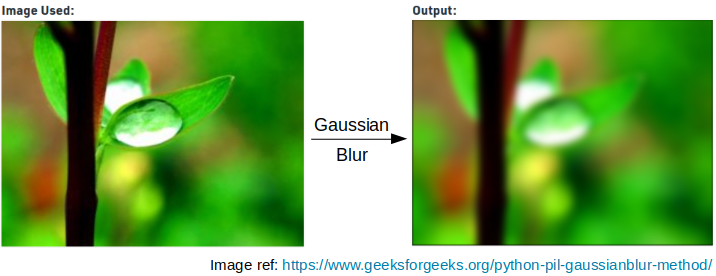



- Solarization (https://www.geeksforgeeks.org/python-pil-imageops-solarize-method/)
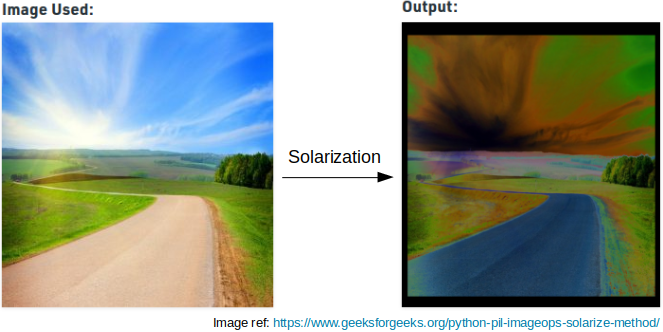

#### Vision Transformer: 'vit_tiny' function
- The code is located in 'vision_transformer.py'

In [ ]:
 # student network: patch_size: 16, kwargs: {'drop_path_rate': 0.1}
 # teacher network: patch_size: 16, kwargs: {}
def vit_tiny(patch_size=16, **kwargs):
    model = VisionTransformer(
        patch_size=patch_size, embed_dim=192, depth=12, num_heads=3, mlp_ratio=4,
        qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model

#### Vision Transformer class

In [ ]:
class VisionTransformer(nn.Module):
    """ Vision Transformer """
    def __init__(self, img_size=[224], patch_size=16, in_chans=3, num_classes=0, embed_dim=768, depth=12,
                 num_heads=12, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop_rate=0., attn_drop_rate=0.,
                 drop_path_rate=0., norm_layer=nn.LayerNorm, **kwargs):
        super().__init__()
        
        # Parameter for vit_tiny case
        # embed_dim=192, num_heads=3, qkv_bias=True, drop_path_rate=0.1
        
        self.num_features = self.embed_dim = embed_dim

        # PatchEmbed: Check the PatchEmbed function
        self.patch_embed = PatchEmbed(
            img_size=img_size[0], patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches # num_patches = 196

        # self.cls_token: which is related to adding [CLS] token to the embed patch tokens.
        #                 It is utilized in the prepare_tokens function.
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer)
            for i in range(depth)])
        # 12 blocks would be generated
        self.norm = norm_layer(embed_dim)

        # Classifier head
        self.head = nn.Linear(embed_dim, num_classes) if num_classes > 0 else nn.Identity()

        trunc_normal_(self.pos_embed, std=.02) # vit_tiny: self.pos_embed.shape = torch.Size([1, 197, 192])
        trunc_normal_(self.cls_token, std=.02) # vit_tiny: self.cls_token = torch.Size([1, 1, 192])
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def interpolate_pos_encoding(self, x, w, h):
        npatch = x.shape[1] - 1
        N = self.pos_embed.shape[1] - 1
        if npatch == N and w == h:
            return self.pos_embed
        class_pos_embed = self.pos_embed[:, 0]
        patch_pos_embed = self.pos_embed[:, 1:]
        dim = x.shape[-1]
        w0 = w // self.patch_embed.patch_size
        h0 = h // self.patch_embed.patch_size
        # we add a small number to avoid floating point error in the interpolation
        # see discussion at https://github.com/facebookresearch/dino/issues/8
        w0, h0 = w0 + 0.1, h0 + 0.1
        patch_pos_embed = nn.functional.interpolate(
            patch_pos_embed.reshape(1, int(math.sqrt(N)), int(math.sqrt(N)), dim).permute(0, 3, 1, 2),
            scale_factor=(w0 / math.sqrt(N), h0 / math.sqrt(N)),
            mode='bicubic',
        )
        assert int(w0) == patch_pos_embed.shape[-2] and int(h0) == patch_pos_embed.shape[-1]
        patch_pos_embed = patch_pos_embed.permute(0, 2, 3, 1).view(1, -1, dim)
        return torch.cat((class_pos_embed.unsqueeze(0), patch_pos_embed), dim=1)

    def prepare_tokens(self, x):
        B, nc, w, h = x.shape
        x = self.patch_embed(x)  # patch linear embedding

        # add the [CLS] token to the embed patch tokens
        cls_tokens = self.cls_token.expand(B, -1, -1) # vit_tiny: (4, 1, 192)
        x = torch.cat((cls_tokens, x), dim=1) # vit_tiny: (4, 197, 192)

        # add positional encoding to each token
        x = x + self.interpolate_pos_encoding(x, w, h)

        return self.pos_drop(x)

    def forward(self, x):
        x = self.prepare_tokens(x)
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        return x[:, 0]

    def get_last_selfattention(self, x):
        x = self.prepare_tokens(x)
        for i, blk in enumerate(self.blocks):
            if i < len(self.blocks) - 1:
                x = blk(x)
            else:
                # return attention of the last block
                return blk(x, return_attention=True)

    def get_intermediate_layers(self, x, n=1):
        x = self.prepare_tokens(x)
        # we return the output tokens from the `n` last blocks
        output = []
        for i, blk in enumerate(self.blocks):
            x = blk(x)
            if len(self.blocks) - i <= n:
                output.append(self.norm(x))
        return output

##### Patch embedding

In [ ]:
class PatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768): # vit_tiny: embed_dim = 192
        super().__init__()
        # (img_size // patch_size) = (224 // 16) = 14
        num_patches = (img_size // patch_size) * (img_size // patch_size) # num_patches = 196
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x

##### Block class
- One of the Vision Transformer compositions

In [ ]:
class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim) # dim = 192: the embeding dimension
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        # 1st block: self.drop_path = nn.Identity()
        # else: self.drop_path = DropPath(drop_path)
        #       (e.g., 2nd: drop_prob = 0.00909090880304575, 3rd: 0.0181818176060915, etc.)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio) # vit_tiny: mlp_hidden_dim = int(192 * 4) = 768
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x, return_attention=False):
        y, attn = self.attn(self.norm1(x))
        if return_attention:
            return attn
        x = x + self.drop_path(y)
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x
        # attn: (4, 3, 197, 197), x: (4, 197, 192), y: (4, 197, 192)

##### Attention class

In [ ]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads # vit_tiny: num_heads = 3
        head_dim = dim // num_heads # vit_tiny: head_dim = 64
        self.scale = qk_scale or head_dim ** -0.5 # vit_tiny: if qk_scale = [], self.scale = 0.125

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias) # vit_tiny: dim = 192 (embedding dimension)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        # Batch x head x N x channel/head
        # k, q, v: (4, 3, 197, 64)
        
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn) # vit_tiny: (4, 3, 197, 197)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x) # vit_tiny: (4, 197, 192)
        return x, attn

##### MLP class
- Composition of Vision Transformer Block class

In [ ]:
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x # vit_tiny: (4, 197, 192)

#### DINOHead class

In [ ]:
class DINOHead(nn.Module):
    def __init__(self, in_dim, out_dim, use_bn=False, norm_last_layer=True, nlayers=3, hidden_dim=2048, bottleneck_dim=256):
        super().__init__()
        # vit_tiny: nlayers = 3
        nlayers = max(nlayers, 1)
        if nlayers == 1:
            self.mlp = nn.Linear(in_dim, bottleneck_dim)
        else:
            # vit_tiny: in_dim = 192, hidden_dim = 2048, bottleneck_dim = 256
            layers = [nn.Linear(in_dim, hidden_dim)]
            if use_bn:
                layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.GELU())
            for _ in range(nlayers - 2):
                layers.append(nn.Linear(hidden_dim, hidden_dim))
                if use_bn:
                    layers.append(nn.BatchNorm1d(hidden_dim))
                layers.append(nn.GELU())
            layers.append(nn.Linear(hidden_dim, bottleneck_dim))
            self.mlp = nn.Sequential(*layers)
        self.apply(self._init_weights)
        self.last_layer = nn.utils.weight_norm(nn.Linear(bottleneck_dim, out_dim, bias=False))
        self.last_layer.weight_g.data.fill_(1)
        if norm_last_layer:
            self.last_layer.weight_g.requires_grad = False

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # vit_tiny: teacher - x(4, 192) / student - x(20, 192)
        x = self.mlp(x)
        # vit_tiny: teacher - x(4, 256) / student - x(20, 256)
        x = nn.functional.normalize(x, dim=-1, p=2)
        x = self.last_layer(x)
        # vit_tiny: teacher - x(4, 65536) / student - x(20, 65536)
        return x

#### MultiCropWrapper
- Located in utils.py

In [ ]:
class MultiCropWrapper(nn.Module):
    """
    Perform forward pass separately on each resolution input.
    The inputs corresponding to a single resolution are clubbed and single
    forward is run on the same resolution inputs. Hence we do several
    forward passes = number of different resolutions used. We then
    concatenate all the output features and run the head forward on these
    concatenated features.
    """
    def __init__(self, backbone, head):
        super(MultiCropWrapper, self).__init__()
        # disable layers dedicated to ImageNet labels classification
        backbone.fc, backbone.head = nn.Identity(), nn.Identity()
        self.backbone = backbone
        self.head = head

    def forward(self, x):
        # convert to list
        if not isinstance(x, list):
            x = [x]
        idx_crops = torch.cumsum(torch.unique_consecutive(
            torch.tensor([inp.shape[-1] for inp in x]),
            return_counts=True,
        )[1], 0)
        start_idx, output = 0, torch.empty(0).to(x[0].device)
        for end_idx in idx_crops:
            _out = self.backbone(torch.cat(x[start_idx: end_idx]))
            # The output is a tuple with XCiT model. See:
            # https://github.com/facebookresearch/xcit/blob/master/xcit.py#L404-L405
            if isinstance(_out, tuple):
                _out = _out[0]
            # accumulate outputs
            output = torch.cat((output, _out))
            start_idx = end_idx
        # Run the head forward on the concatenated features.
        return self.head(output)
        # vit_tiny: teacher - x(4, 192) / student - (20, 192)

#### Dino loss

In [ ]:
class DINOLoss(nn.Module):
    def __init__(self, out_dim, ncrops, warmup_teacher_temp, teacher_temp,
                 warmup_teacher_temp_epochs, nepochs, student_temp=0.1,
                 center_momentum=0.9):
        super().__init__()
        self.student_temp = student_temp # 0.1
        self.center_momentum = center_momentum # 0.9
        self.ncrops = ncrops # 10
        self.register_buffer("center", torch.zeros(1, out_dim))
        # we apply a warm up for the teacher temperature because
        # a too high temperature makes the training instable at the beginning
        self.teacher_temp_schedule = np.concatenate((
            np.linspace(warmup_teacher_temp,
                        teacher_temp, warmup_teacher_temp_epochs), # (0.04, 0.04, 0)
            np.ones(nepochs - warmup_teacher_temp_epochs) * teacher_temp
        ))

    def forward(self, student_output, teacher_output, epoch):
        """
        Cross-entropy between softmax outputs of the teacher and student networks.
        """
        # student_output: (20, 65536) / teacher_output: (4, 65536)
        student_out = student_output / self.student_temp
        student_out = student_out.chunk(self.ncrops)
        # student_out: tuple: 10 (i.e., (2, 65536)*10)

        # teacher centering and sharpening
        temp = self.teacher_temp_schedule[epoch]
        teacher_out = F.softmax((teacher_output - self.center) / temp, dim=-1)
        teacher_out = teacher_out.detach().chunk(2)
        # teacher_out: tuple: 2 (i.e., (2, 65536)*2)

        total_loss = 0
        n_loss_terms = 0
        for iq, q in enumerate(teacher_out):
            for v in range(len(student_out)):
                if v == iq:
                    # we skip cases where student and teacher operate on the same view
                    continue
                loss = torch.sum(-q * F.log_softmax(student_out[v], dim=-1), dim=-1)
                total_loss += loss.mean()
                n_loss_terms += 1
        total_loss /= n_loss_terms
        self.update_center(teacher_output)
        return total_loss

    @torch.no_grad()
    def update_center(self, teacher_output):
        """
        Update center used for teacher output.
        """
        batch_center = torch.sum(teacher_output, dim=0, keepdim=True)
        dist.all_reduce(batch_center)
        batch_center = batch_center / (len(teacher_output) * dist.get_world_size())

        # ema update
        self.center = self.center * self.center_momentum + batch_center * (1 - self.center_momentum)

### Training (function: train_one_epoch)

In [ ]:
def train_one_epoch(student, teacher, teacher_without_ddp, dino_loss, data_loader,
                    optimizer, lr_schedule, wd_schedule, momentum_schedule,epoch,
                    fp16_scaler, args):
    metric_logger = utils.MetricLogger(delimiter="  ")
    header = 'Epoch: [{}/{}]'.format(epoch, args.epochs)

    for it, (images, _) in enumerate(metric_logger.log_every(data_loader, 10, header)):
        # At this point, the saved data augmentation process would be conducted to the image.
        # 1. Random resizing


        # update weight decay and learning rate according to their schedule
        it = len(data_loader) * epoch + it  # global training iteration
        for i, param_group in enumerate(optimizer.param_groups):
            param_group["lr"] = lr_schedule[it]
            if i == 0:  # only the first group is regularized
                param_group["weight_decay"] = wd_schedule[it]

        # move images to gpu
        images = [im.cuda(non_blocking=True) for im in images]
        # teacher and student forward passes + compute dino loss
        
        with torch.cuda.amp.autocast(fp16_scaler is not None):
            # only the 2 global views pass through the teacher (e.g., two [64, 3, 224, 224] sizes of images)
            teacher_output = teacher(images[:2])
            # Go through the 'MultiCropWrapper' - backbone -> head
            # Backbone network: prepare tokens -> blocks -> layer norm.
            # vit_tiny teacher_output: (4, 65536)

            student_output = student(images)
            # vit_tiny student_output: (20, 65536)

            # loss: measures cross-entropy between softmax outputs of the teacher and student networks.
            loss = dino_loss(student_output, teacher_output, epoch)

        if not math.isfinite(loss.item()):
            print("Loss is {}, stopping training".format(loss.item()), force=True)
            sys.exit(1)

        # student update
        optimizer.zero_grad()
        param_norms = None
        if fp16_scaler is None:
            loss.backward()
            if args.clip_grad:
                param_norms = utils.clip_gradients(student, args.clip_grad)
            utils.cancel_gradients_last_layer(epoch, student,
                                              args.freeze_last_layer)
            optimizer.step()
        else:
            fp16_scaler.scale(loss).backward()
            if args.clip_grad:
                fp16_scaler.unscale_(optimizer)  # unscale the gradients of optimizer's assigned params in-place
                param_norms = utils.clip_gradients(student, args.clip_grad)
            utils.cancel_gradients_last_layer(epoch, student,
                                              args.freeze_last_layer)
            fp16_scaler.step(optimizer)
            fp16_scaler.update()

        # EMA update for the teacher
        with torch.no_grad():
            m = momentum_schedule[it]  # momentum parameter
            for param_q, param_k in zip(student.module.parameters(), teacher_without_ddp.parameters()):
                param_k.data.mul_(m).add_((1 - m) * param_q.detach().data)

        # logging
        torch.cuda.synchronize()
        metric_logger.update(loss=loss.item())
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])
        metric_logger.update(wd=optimizer.param_groups[0]["weight_decay"])
    # gather the stats from all processes
    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)
    return {k: meter.global_avg for k, meter in metric_logger.meters.items()}

#### Image
- Utilized CIFAR 10

- Input and transformed image example
  - Global for teacher network
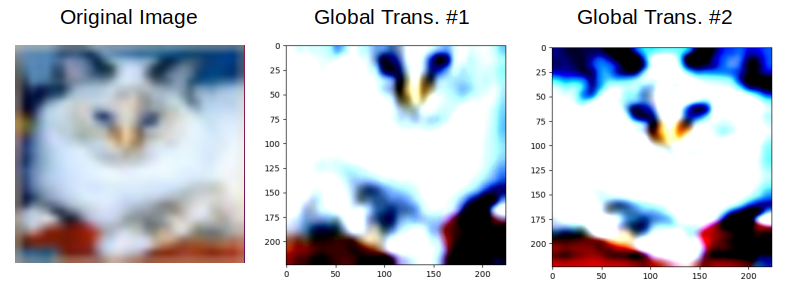

  - Local for student network
  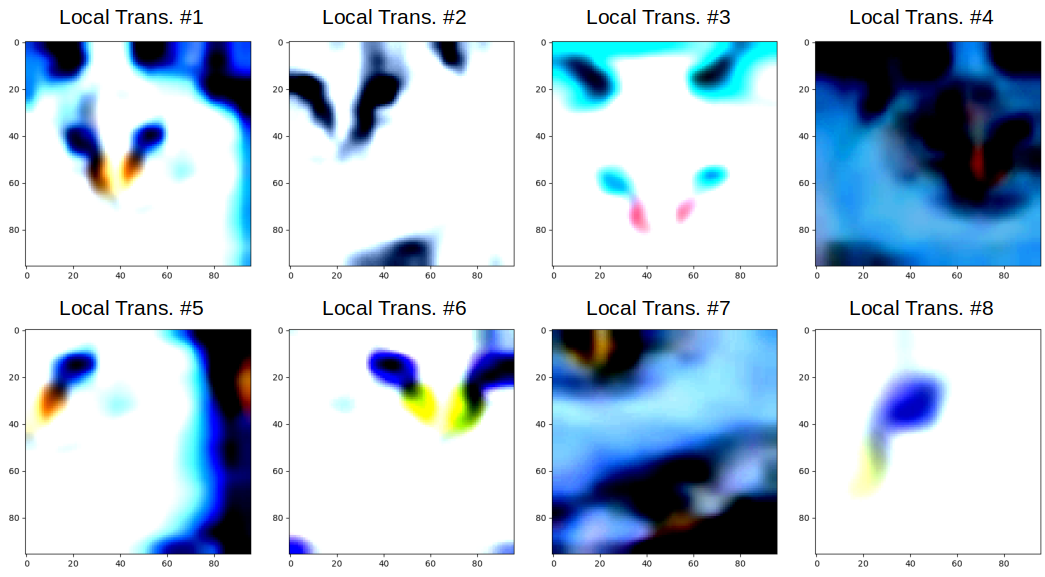


In [ ]:
if __name__ == '__main__':
    parser = argparse.ArgumentParser('DINO', parents=[get_args_parser()])
    args = parser.parse_args()
    Path(args.output_dir).mkdir(parents=True, exist_ok=True)
    train_dino(args)